# RC Temporal Subsampling with mixed Macro Cost

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import seaborn as sns

from ddc import YAMLParser
from sqgtools import XSQGTurb, SpectrumPlotter

In [2]:
sys.path.append("..") 
from rcgfd import RCDataset, BigPlot, plot_ke_relerr

In [3]:
plt.style.use("./rc-gfd.mplstyle")

In [4]:
fig_dir = "../figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [5]:
rcd = RCDataset(
    n_sub=[1,4,16],
    cost_terms = [
        {"nrmse": 1},
        {"nrmse": 1, "spectral": 0.0001},
        {"nrmse": 1, "spectral": 0.001},
        {"nrmse": 1, "spectral": 0.01},
        # this one is just shit
        #{"nrmse": 1, "global-integral": 0.0001},
    ]
)

In [6]:
ds = rcd()

Grab one sample for some plotting

In [19]:
xds = ds.sel(sample=2,
             n_sub=16,
             experiment=['nrmse1.0e+00',
                         'nrmse1.0e+00-spectral1.0e-04',
                         'nrmse1.0e+00-spectral1.0e-03',
                        ])

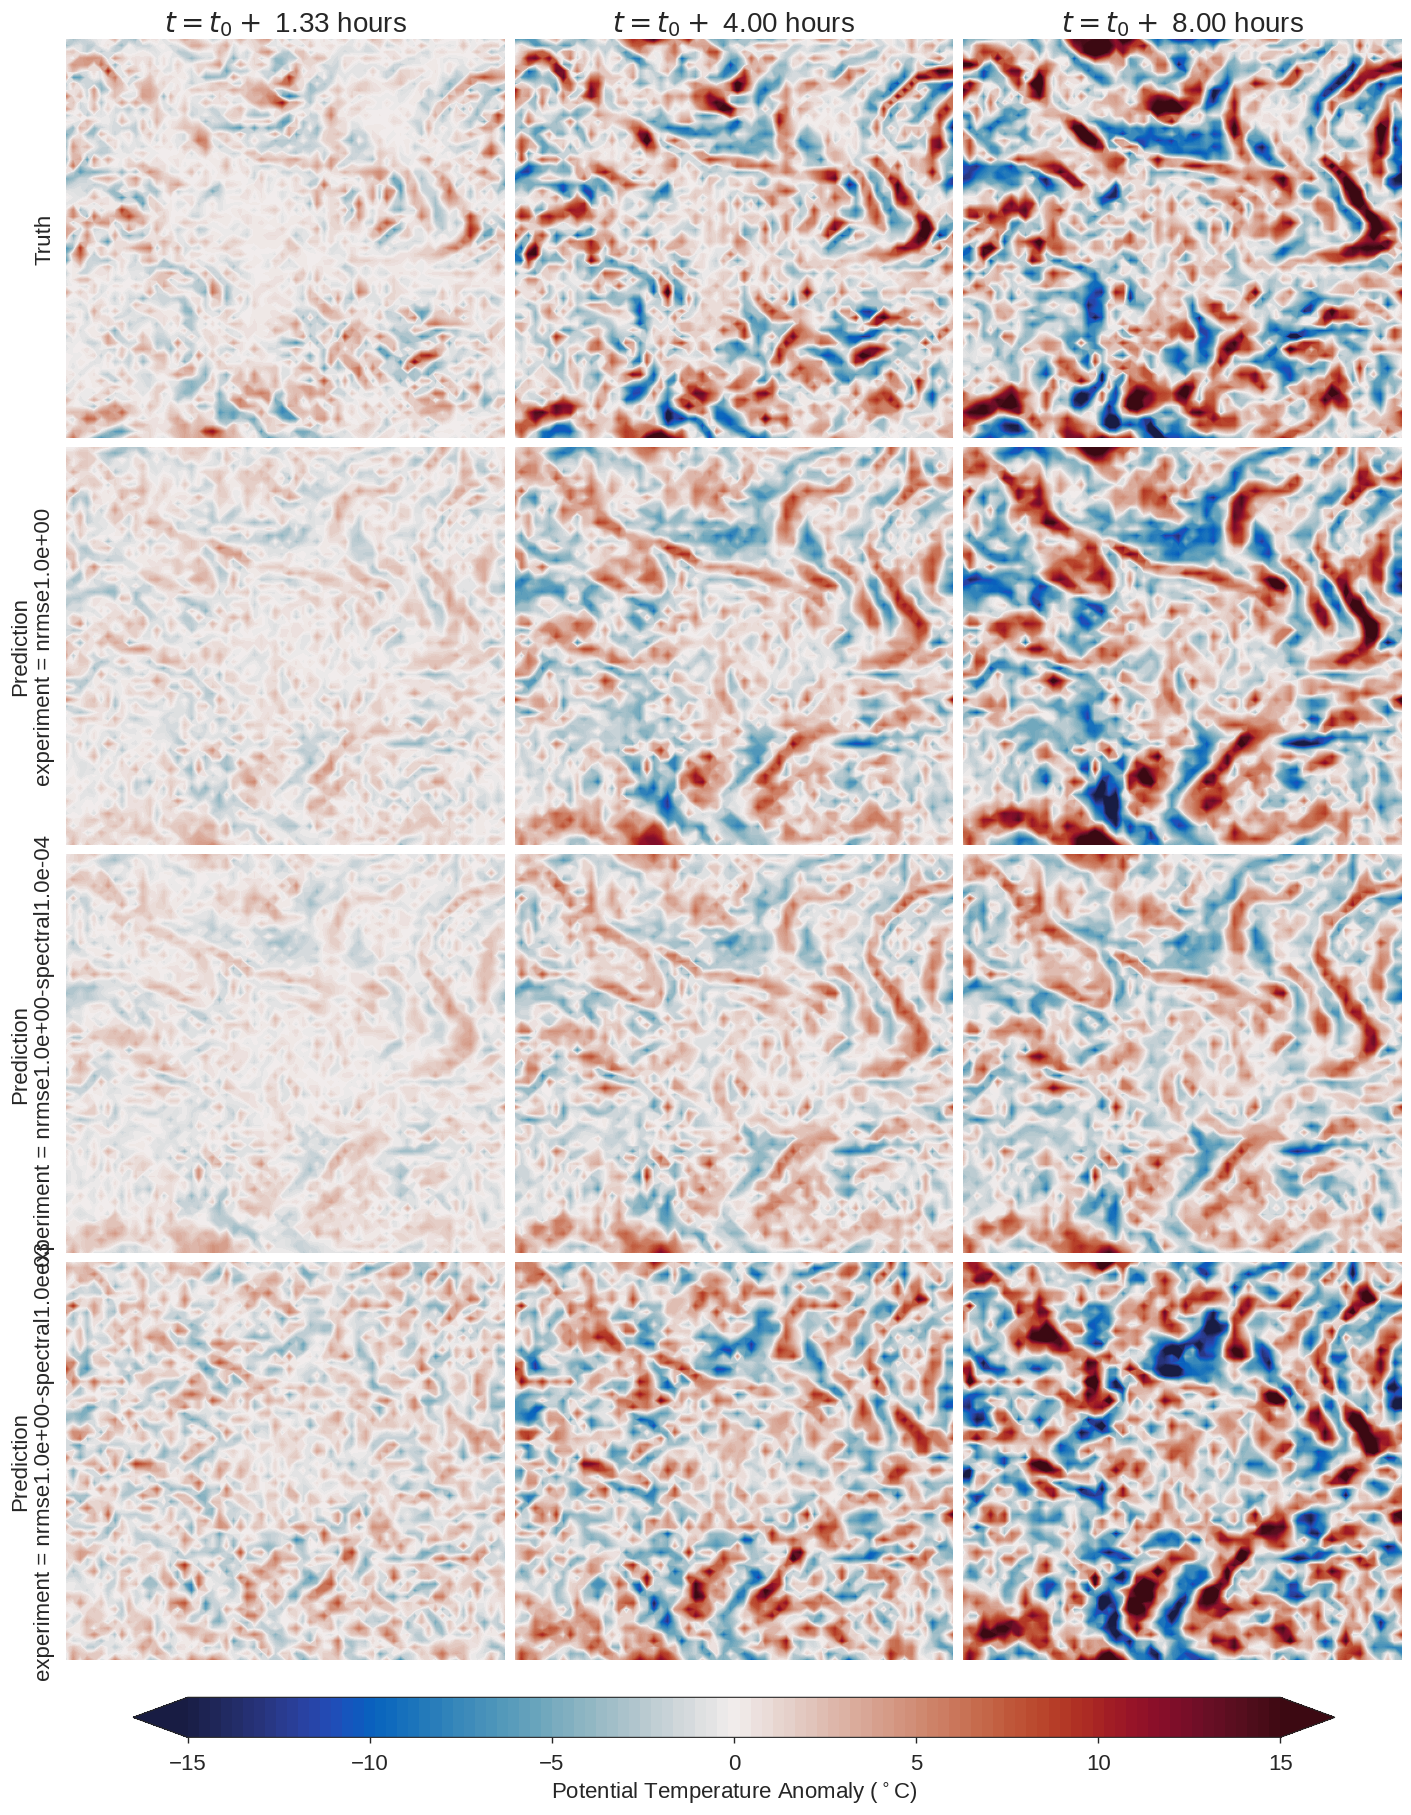

In [20]:
bp = BigPlot()
fig, axs = bp(xds, row_dim="experiment")

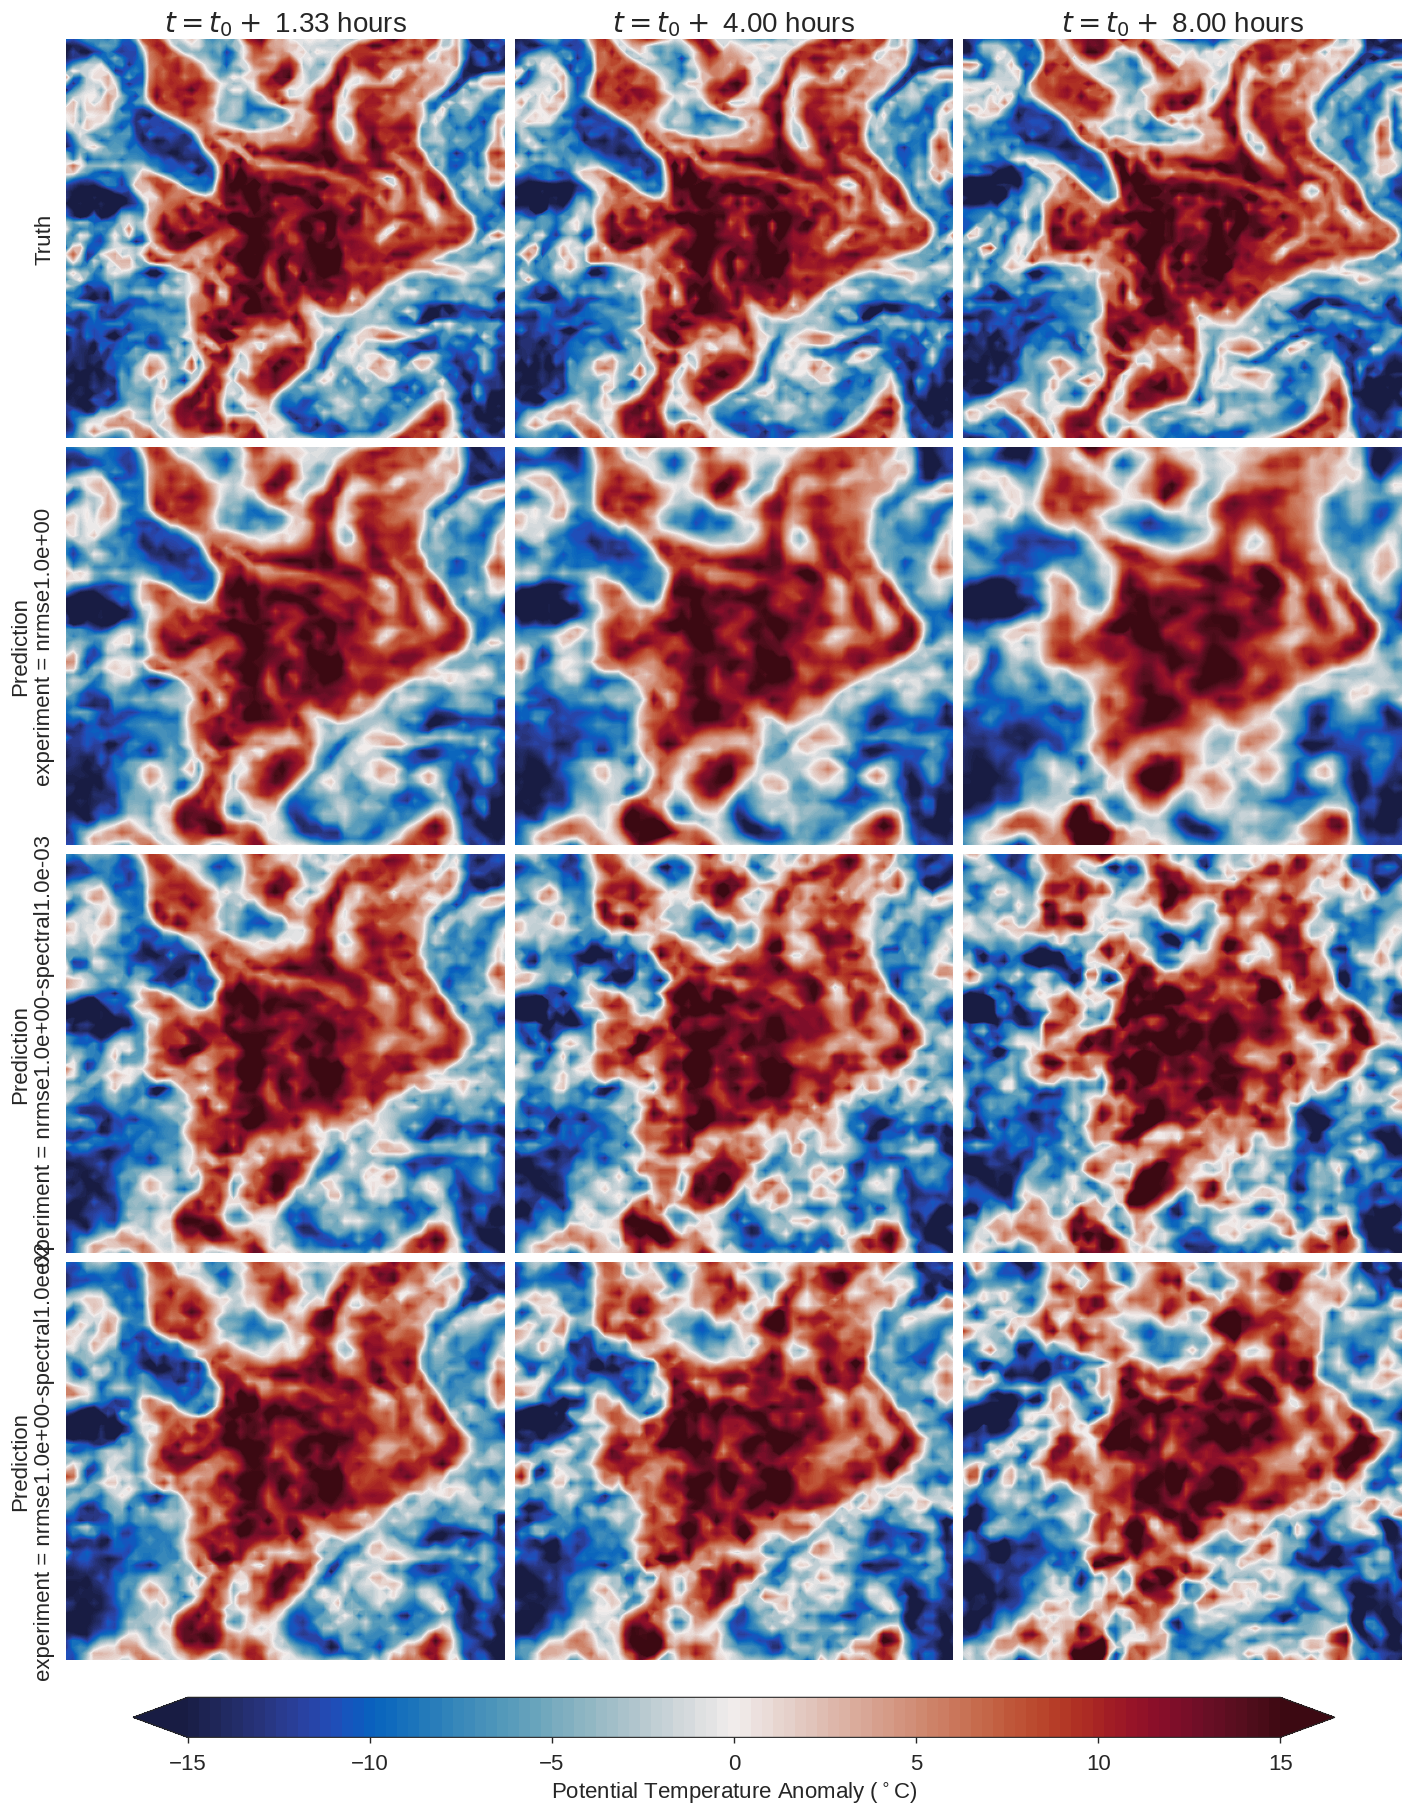

In [9]:
bp = BigPlot(diff_t0=False)
fig, axs = bp(xds, row_dim="experiment")

In [10]:
ep = BigPlot(prediction="absolute_error",
             cbar_label=r"Absolute Error ($^\circ C$)",
             cmap="viridis",
             plot_truth=False,
             vmax=10,
             vmin=0,
             subplot_kw={
                 "figsize":(14,14),
                 "constrained_layout": True,
             }
            )

In [11]:
#fig, axs = ep(xds, row_dim="experiment")

## NRMSE, ACC

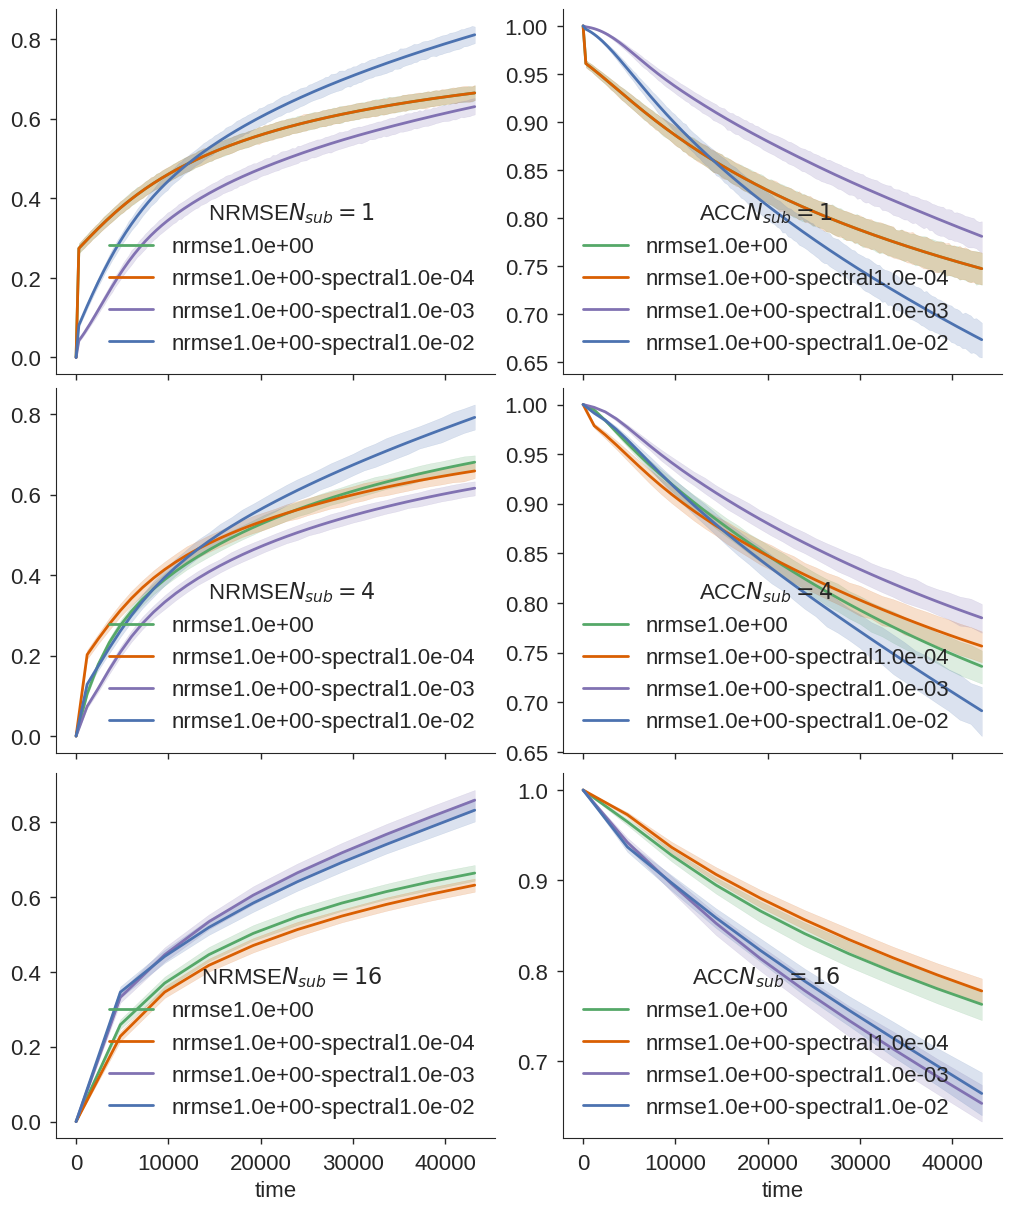

In [14]:
nrows = len(ds.n_sub)
ncol = len(xds.experiment)
fig, axs = plt.subplots(nrows, 2, figsize=(10,4*nrows), sharex=True, constrained_layout=True)

for n_sub, axr in zip(ds.n_sub.values, axs):
    for metric, ax in zip(["nrmse", "acc"], axr):
        for experiment in ds.experiment.values:
            plotme = ds.sel(experiment=experiment, n_sub=n_sub)
            plotme = plotme[metric].to_dataset()
            df = plotme.to_dataframe().reset_index()
            sns.lineplot(
                data=df,
                x="time",
                y=metric,
                ax=ax,
                label=experiment,
            )
        ax.set(ylabel="")
        ax.legend(title=xds[metric].label + r"$N_{sub} = %d$" % n_sub)

- With Nsub=16, not a huge difference between using the spectrum or not, but best is with penalty at $10^{-4}$
- With Nsub=4, spectral penalty is a bit more clear. Now the optimal is with penalty at $10^{-3}$

... but... see a real tradeoff with spectrum here. With Nsub=4, hit spectrum better but worse RMSE

TBD: Nsub=1...

## Spectra

In [10]:
time = np.array([1.3333, 4, 8, 12])*3600
xds = ds.sel(time=time,method="nearest")

In [11]:
xsqg = XSQGTurb()
ktrue = xsqg.calc_kespec1d(xds["truth"].load())
kpred = xsqg.calc_kespec1d(xds["prediction"].load())

In [12]:
kerr = kpred - ktrue
relerr = np.abs(kerr/ktrue)

In [13]:
def exp_label(exp):
    split = exp.split("-spectral")
    alpha = split[0].split("nrmse")[-1]
    beta = 0 if len(split)==1 else split[1].split("spectral")[-1]
    
    alpha = int(np.log10(float(alpha)))
    beta = float(beta)
    beta = int(np.log10(beta)) if beta != 0 else -16
    
    return r"$\alpha = 10^{%d}, \beta = 10^{%d}$" % (alpha, beta)

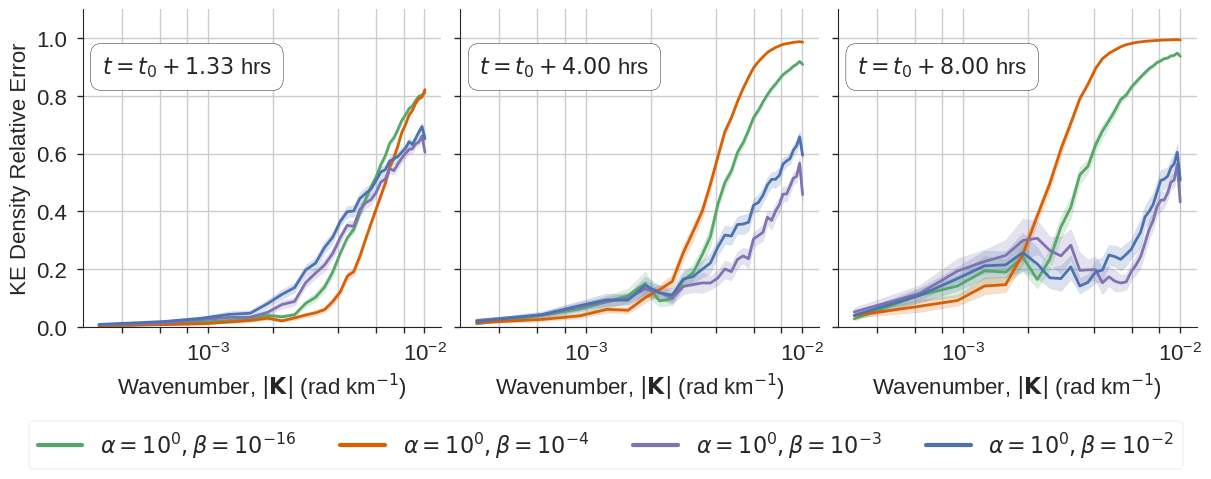

In [46]:
fig, axs = plot_ke_relerr(relerr.sel(n_sub=16), errorbar="ci", cdim="experiment", clabel=exp_label)

In [40]:
re_select = xr.concat([
    relerr.sel(n_sub=1 ,experiment="nrmse1.0e+00-spectral1.0e-03").drop("experiment"),
    relerr.sel(n_sub=4 ,experiment="nrmse1.0e+00-spectral1.0e-04").drop("experiment"),
    relerr.sel(n_sub=16,experiment="nrmse1.0e+00-spectral1.0e-04").drop("experiment"),
], dim="n_sub")

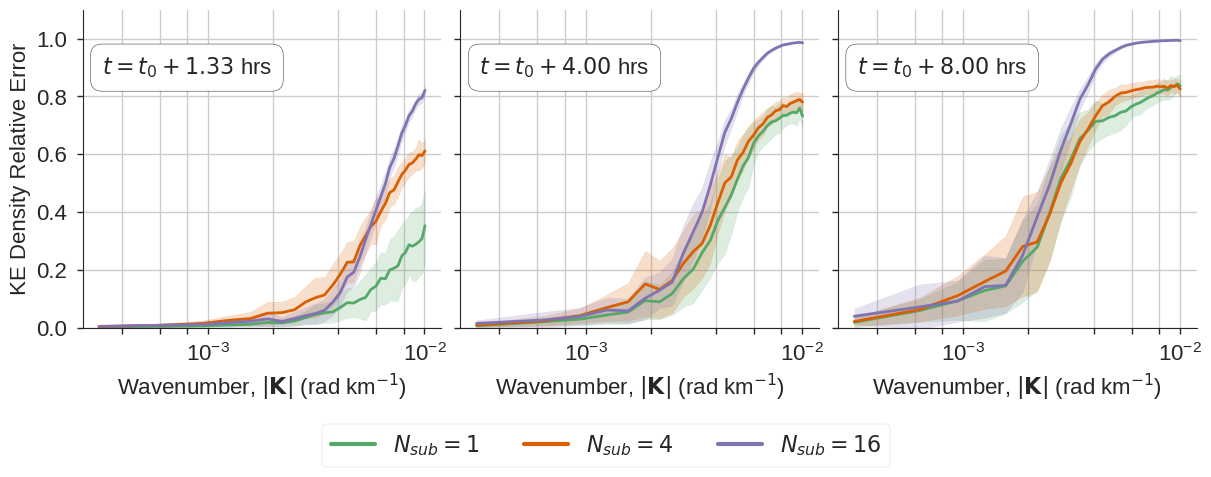

In [43]:
fig, axs = plot_ke_relerr(re_select, errorbar="sd", cdim="n_sub")

In [43]:
bp = BigPlot(diff_t0=False)

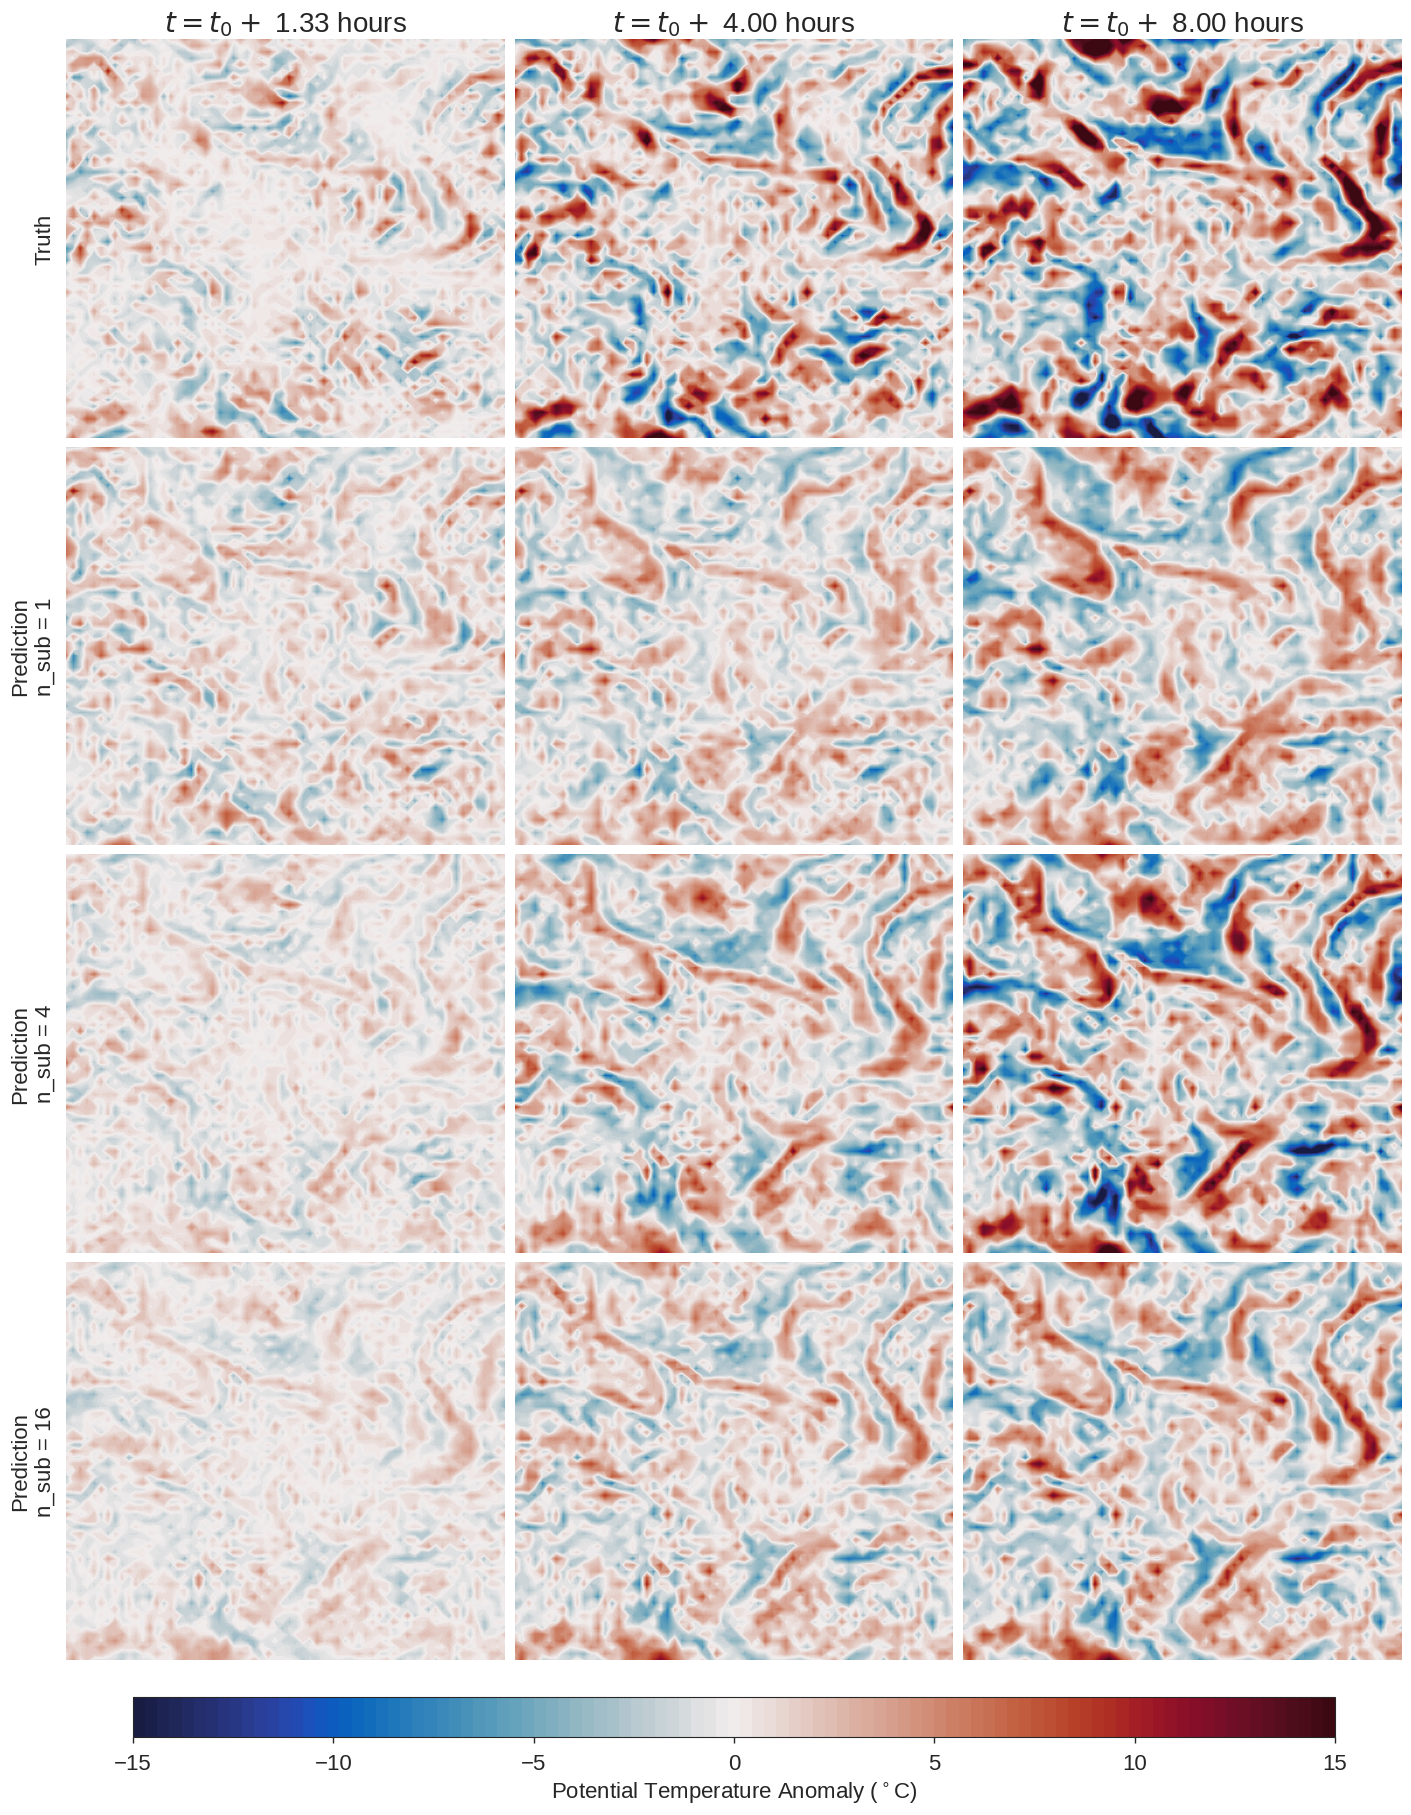

In [45]:
bp(ds.sel(experiment="nrmse1.0e+00-spectral1.0e-04",sample=2), row_dim="n_sub");

## Global Integral

[Text(0, 0.5, 'Global Integral')]

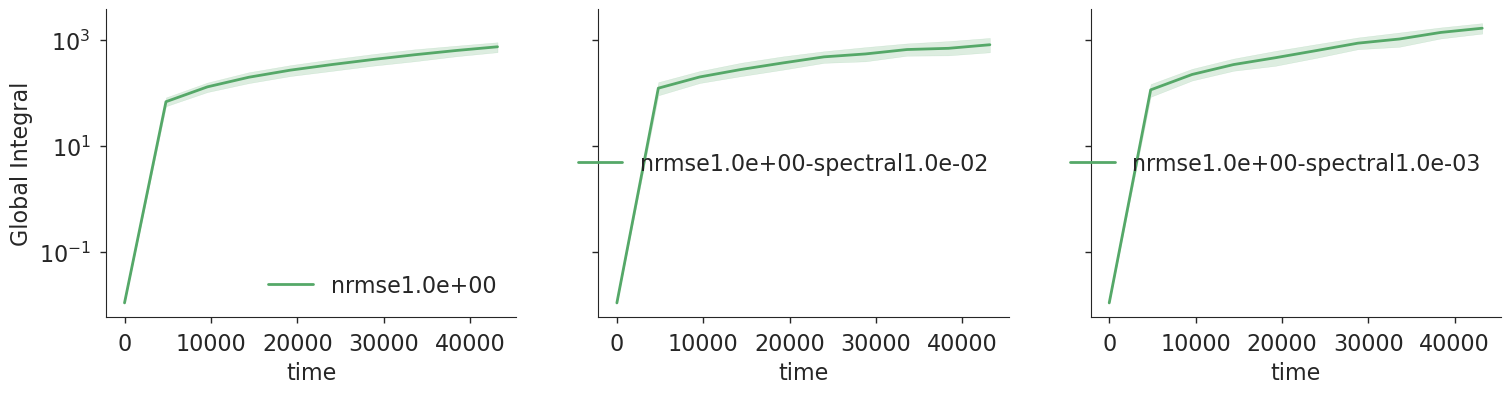

In [22]:
fig, axs = plt.subplots(1,3, figsize=(18,4), sharey=True)

for experiment, ax in zip(ds.experiment.values, axs):
    dims = ("x", "y", "z")
    plotme = ds["prediction"].sel(experiment=experiment).sum(dims)
    plotme = np.abs(plotme)
    plotme=plotme.to_dataframe()
    sns.lineplot(
        data=plotme,
        x="time",
        y="prediction",
        ax=ax,
        label=experiment)
    
    ax.set(yscale="log")
    
axs[0].set(ylabel="Global Integral")